# 自变量与因变量处理

## 因变量

（1）个股收益率

本文的目的是考察股票价格水平与其收益率之间的内在影响关系，因而我们的因变量是个股收益率(Ｒeturn) 。鉴于本文的研究样本主要为月度数据，我们采用个股考虑现金红利再投资的月回报率减去无风险收益率的值作为衡量个股收益率的指标，其中无风险收益率等于月度化的一年期的银行存款利率。

## 自变量

根据研究假设，本文的自变量包括股票价格、散户规模、机构投资者持股比例、证券分析师关注度、卖空机制五个变量。

（1） 股票价格(PRICE) 。本文以上市公司股票的月末收盘价来衡量股票的价格水平。

（2） 散户规模(RETAIL) 。考虑到不同上市公司之间的股本总额和市值存在较大差异，散户人数不存在直接可比的基础，因而本文以股东人数与总股份数的比值乘以10000 来反映上市公司的散户规模，即平均每一万股股份所对应的股东人数，该值越大，说明散户规模越大。

（3） 机构投资者持股比例(INSTI) 。机构投资者持股比例等于所有机构投资者持有股份总数与公司总股份数的比例。

（4） 证券分析师
关注度(ANALY) 。借鉴朱红军等( 2007) 的度量方法，证券分析师关注度( ANALY) 等于当月对上市公司进行跟踪分析的证券分析师人数加1 后的自然对数值。

（5）卖空机制(SELL) 。本文借鉴李科等( 2014) 、李志生等( 2015) 的做法，构建了一个卖空机制哑变量( SELL) 。若公司股票当月为融资融券标的股，则取值为1，否则取值为0。

In [3]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import random
import os
from scipy.stats.mstats import winsorize
from datetime import datetime
from functools import reduce
from pandas.tseries.offsets import *
import statsmodels.api as sm
import statsmodels.formula.api as smf

#os.chdir(r'E:\python3\2020_Seminar\2021春季学习班\自行实现文档\7.1文献复制\自变量原始数据')

In [ ]:
# 读取因变量数据并转换为长列表
Return = pd.read_csv('E:\python3\\2020_Seminar\\2021春季学习班\自行实现文档\\7.1文献复制\因变量原始数据\月超额收益率A.csv')
Return.rename(columns = {'Unnamed: 0':'month'},inplace=True)
Return = Return[(Return['month'] >= 199901) & (Return['month'] <= 202012)]
Return['month'] = Return['month'].apply(lambda x:str(x)[:-4] + '-' + str(x)[-4:-2])
# 提取样本期所有月份，便于后续对季度数据进行填充
all_months = Return['month']
# 将收益转换为长列表
Return = pd.melt(Return,id_vars=['month'],value_vars=Return.columns.drop('month'),var_name='stkcd',value_name='Return')
Return['stkcd'] = Return['stkcd'].apply(lambda x:str(x).zfill(6))

In [ ]:
# 读取自变量数据文件
sell = pd.read_excel('CHN_Stkmt_mdetails.xlsx')
shareholder_num = pd.read_excel('股东户数（季频）.xlsx')
insti = pd.read_excel('机构投资者持股比例（季频）.xlsx')
shares_num = pd.read_excel('TRD_Capchg.xlsx')
markettype = pd.read_excel('TRD_Co.xlsx')
price = pd.read_excel('TRD_Mnth.xlsx')
debt = pd.read_excel('FI_T1.xlsx')
analy = pd.read_csv('82_nanalyst.csv')

In [ ]:
# 处理自变量
# 修改自变量列名与删除多余列,将股票代码与月份格式统一
sell = sell.rename(columns = {'Mtmonth':'month',
                              'Stockcode':'stkcd'}).drop(['Stockname','Exchangecode'],axis=1).iloc[2:,:]
sell['sell'] = 1

# 股东人数有部分数据月内不同日期均有取值，第一日为变动前一天股东数，与上一次记录人数相同，第二日为变动后股东人数
# 故去重保留第二日变动后信息
shares_num = shares_num.rename(columns = {'Stkcd':'stkcd','Shrchgdt':'month','Nshrttl':'shares_num'})\
    .drop('Shrtyp',axis=1).iloc[2:,:]
shares_num['month'] = shares_num['month'].apply(lambda x:str(x)[:7])
shares_num = shares_num.drop_duplicates(subset=['stkcd','month'],keep='last')

# 处理股票所属行业，是否在B股或H股交叉上市
markettype = markettype.rename(columns = {'Stkcd':'stkcd','Crcd':'AB_cross','Commnt':'H_cross'})\
    .drop(['Stknme','Listdt'],axis=1).iloc[2:,:]
markettype['industry'] = markettype['Nindcd'].apply(lambda x:x[0])
markettype = markettype.drop('Nindcd',axis=1)
markettype = markettype.replace(np.nan,0)

# 股票月末收盘价
price = price.rename(columns = {'Stkcd':'stkcd','Trdmnt':'month','Mclsprc':'price'}).iloc[2:,:]

# 资产负债率，之后删除大于一的资不抵债样本
debt = debt[debt['Typrep'] == 'A']
debt = debt.rename(columns = {'Stkcd':'stkcd','Accper':'month','F011201A':'debt'})\
           .drop('Typrep',axis=1).iloc[2:,:]
debt['month'] = debt['month'].apply(lambda x:str(x)[:7])

# 分析师关注人数直接使用异象因子库中数据(+1取对数),0表示无分析师关注，不用替换为缺失值
analy = analy.rename(columns={'index':'month'})
analy = pd.melt(analy,id_vars=['month'],value_vars=analy.columns.drop('month')
                ,var_name='stkcd',value_name='analy')
analy['stkcd'] = analy['stkcd'].apply(lambda x:str(x).zfill(6))
analy['month'] = analy['month'].apply(lambda x:str(x)[:-4] + '-' + str(x)[-4:-2])
analy['analy'] = np.log(1 + analy['analy'])

# 因子库里是用于分组的变量值（例如200001行的单元格中，实际填写的是199912末的因子值），因此需要将年份月份-1
# 由于analy表中每只股票代码日期向下递增排列，因此可groupby + shift简化处理
analy['analy1'] =  analy.groupby('stkcd')['analy'].shift(-1)
analy = analy.drop('analy',axis=1).rename(columns={'analy1':'analy'})

# 股东人数和机构持股比例用的wind数据，下载时已经剔除了金融股
# （以后没必要，后面用行业代码统一剔除）
for wind_v in ['shareholder_num','insti']:
    globals()[wind_v] = globals()[wind_v].rename(columns = {'Unnamed: 0':'stkcd'}).drop('Unnamed: 1',axis=1)
    globals()[wind_v]['stkcd'] = globals()[wind_v]['stkcd'].apply(lambda x: x[:-3])
    globals()[wind_v] = pd.melt(globals()[wind_v],id_vars=['stkcd'],value_vars=globals()[wind_v].columns.drop('stkcd'),
                              var_name='month',value_name=wind_v)
    globals()[wind_v]['month'] = globals()[wind_v]['month'].apply(lambda x: str(x)[:7])
    # 数值为0实际代表数据缺失，替换为nan
    globals()[wind_v][wind_v] = globals()[wind_v][wind_v].replace(0,np.nan)

In [ ]:
# 合并所有月度数据 (markettype中不含月份)
monthly_frame = \
    reduce(lambda left, right: pd.merge(left, right, on=['month','stkcd'],how='outer'), [Return,analy,sell,price])

# 将月度数据中sell的缺失值全部替换为0（意味着没有被记录，非融资融券标的），删除存在相关变量缺失的数据
monthly_frame['sell'] = monthly_frame['sell'].replace(np.nan,0)

# 将季度数据（shareholder_num,insti,debt）与月份间隔不规律的shares_num转换为宽列表便于进行月度填充
for seasonal_v in ['shareholder_num','insti','debt','shares_num']:
    globals()[seasonal_v + '_wide'] = \
        pd.pivot(globals()[seasonal_v],index='month', columns='stkcd')[seasonal_v].reset_index()
    # 先与月度表格的月份拼接，这里选取因变量Return
    globals()[seasonal_v + '_wide'] = \
        pd.merge(all_months, globals()[seasonal_v + '_wide'],on = 'month',how='left')
    # 进行月度填充
    globals()[seasonal_v + '_wide'] = globals()[seasonal_v + '_wide'].fillna(method='ffill')
    # 将月度宽列表转换回长列表
    globals()[seasonal_v] = pd.melt(globals()[seasonal_v + '_wide'],id_vars=['month'], value_vars=globals()[seasonal_v + '_wide'].columns.drop('month'),
            var_name='stkcd', value_name=seasonal_v)

# 将季度数据转化成的月度数据表格拼接
monthly_seasonal_frame = \
    reduce(lambda left, right: pd.merge(left, right, on=['month', 'stkcd'], how='outer'),
           [shareholder_num,insti,debt,shares_num])   

# 将所有月度长表格进行拼接
monthly_frame = \
    reduce(lambda left, right: pd.merge(left, right, on=['month', 'stkcd'], how='outer'),
           [monthly_frame,monthly_seasonal_frame])

# 计算散户规模并删除中间数据
monthly_frame['retail'] = monthly_frame['shareholder_num']/monthly_frame['shares_num'] * 10000
monthly_frame = monthly_frame.drop(['shares_num','shareholder_num'],axis=1)

In [ ]:
# 与文章保持一致，只选取199901到201412样本
monthly_frame['month'] = monthly_frame['month'].apply(lambda x:float(x[:4]+x[-2:]))
monthly_frame = monthly_frame[(monthly_frame['month']>=199901)&(monthly_frame['month']<=201412)]
monthly_frame = monthly_frame.dropna()

# 删除交叉上市，金融保险业以及资不抵债样本
monthly_frame = pd.merge(monthly_frame,markettype,on=['stkcd'],how='left')
monthly_frame = monthly_frame[(monthly_frame['industry'] != 'I')&(monthly_frame['AB_cross'] == 0)
                              &(monthly_frame['H_cross'] == 0)&(monthly_frame['debt'] <= 1)]

# price先开始在describe里显示不出来，查找原因发现不为数值型

# 制作表2描述性统计分析
monthly_frame['price'] = monthly_frame['price'].apply(lambda x:float(x))
de_ind_v = monthly_frame[['month','stkcd','Return','price','retail','insti','analy','sell']]
# 对变量进行缩尾（这里sell取值为0,1，缩尾应该不影响）
# de_ind_summary = de_ind_v.groupby('month').apply(lambda x:x.clip(lower=de_ind_v.quantile(0.01),
#                                                             upper=de_ind_v.quantile(0.99),axis=1))
# de_ind_summary = de_ind_v.drop('month',axis=1).describe().T
# de_ind_summary.rename(columns = {'25%':'P25','50%':'P50','75%':'P75'},inplace = True)
# print(de_ind_summary)

de_ind_v.to_csv(r'E:\python3\2020_Seminar\2021春季学习班\自行实现文档\7.1文献复制\中间数据\de_ind_v.csv')

# 控制变量处理

借鉴 Harvey and Siddique $(2000)$ 、mihud $(2002)$, Ang et al. $(2006)$ 等关于股票收益率的研究文献, 本文控制了非流动性指标（ILLIQ）、特质波动率 $(I V O L)$ 、特质偏 度 $(S K E W)$ 协偏 度 $(C O S K E W)$ 、贝塔系数 $(B E T A)$ 、股票换手率 $(T U R)$ 、市值账面比率 $(L E V)$ 公司规模 $(S I Z E)$ 、上市时长 $(A G E)$ 、上一期股票收益率 $(R E T)$ 月度最大收益 率 $(M A X)$ 等其他因素可能对上市公司股票收益率产生的系统影响。

此外, 本文还引入了行业显变量 (Industry) 和年度显变量 $(Y e a r)$ 以控制行业效应和年度效应。特别地, 当变量只能获取到季度数据时,我们用季度数据替代月度数据。控制变量的符号与具体定义

![img](control_v1.PNG)
![img](control_v2.PNG)

In [ ]:
# 上市市场与行业
markettype = pd.read_excel('TRD_Co.xlsx')
markettype = markettype.rename(columns = {'Stkcd':'stkcd','Crcd':'AB_cross','Commnt':'H_cross'})\
    .drop(['Stknme','Listdt'],axis=1).iloc[2:,:]
markettype['industry'] = markettype['Nindcd'].apply(lambda x:x[0])
markettype = markettype[['stkcd','industry']]

price = pd.read_excel('TRD_Mnth.xlsx')
price = price.rename(columns = {'Stkcd':'stkcd','Trdmnt':'month','Mclsprc':'price'}).iloc[2:,:]

df = pd.merge(markettype,price,on='stkcd')
df['year'] = df['month'].apply(lambda x:x[:4])

# 生成哑变量
year_dummy = pd.get_dummies(df['year'])
ind_dummy = pd.get_dummies(df['industry'])

# 合并
df_dummy = pd.merge(df, year_dummy, left_index=True, right_index=True, how='outer')
df_dummy = pd.merge(df_dummy, ind_dummy, left_index=True, right_index=True, how='outer')

df_dummy = df_dummy.drop(['industry','price','year'],axis=1)
df_dummy['month'] = df_dummy['month'].apply(lambda x:int(x[:4]+x[5:7]))
# df_dummy.to_csv(r'E:\python3\2020_Seminar\2021春季学习班\自行实现文档\7.1文献复制\中间数据\dummy_v.csv')

In [ ]:
# 读取除哑变量外控制变量
Return = pd.read_csv('月超额收益率A.csv')
tur = pd.read_excel('tur.xlsx')
cash = pd.read_csv('cash.csv')
# eps = pd.read_excel('eps.xlsx')
lev = pd.read_csv('lev.csv')
size = pd.read_csv('size.csv')
beta = pd.read_csv('03_beta.csv')
mtb = pd.read_csv('31_am.csv')
roa = pd.read_csv('60_ROA.csv')
age = pd.read_csv('68_age.csv')
retnmax = pd.read_csv('17_retnmax.csv')
illiq = pd.read_csv('15_illq.csv')
idvol = pd.read_csv('06_idvol.csv')
skew = pd.read_csv('08_idskew.csv')
coskew = pd.read_csv('10_coskew.csv')

In [ ]:
# 处理国泰安下载的月度数据
tur = tur.rename(columns = {'Stkcd':'stkcd','Trdmnt':'month',
                            'ToverOsM':'tur'}).iloc[2:,:]
tur['month'] = tur['month'].apply(lambda x:int(x[:4]+x[5:7]))

size = size.rename(columns = {'Stkcd':'stkcd','Trdmnt':'month',
                            'Msmvttl':'size'})
size['size'] = np.log(size['size'])
size['stkcd'] = size['stkcd'].apply(lambda x:str(x).zfill(6))
size['month'] = size['month'].apply(lambda x:int(x[:4]+x[5:7]))

# 处理国泰安下载的季度数据
eps = cash.copy()
eps = eps.rename(columns = {'Stkcd':'stkcd','Accper':'month',
                              'F090102B':'eps'}).iloc[2:,:]
eps = eps[eps['Typrep'] == 'A']
eps = eps.drop(['Typrep','F091802B'],axis=1)
eps['stkcd'] = eps['stkcd'].apply(lambda x:str(x).zfill(6))

cash = cash.rename(columns = {'Stkcd':'stkcd','Accper':'month',
                              'F091802B':'cash'})
cash = cash[cash['Typrep'] == 'A']
cash = cash.drop(['F090102B','Typrep'],axis=1)
cash['stkcd'] = cash['stkcd'].apply(lambda x:str(x).zfill(6))

lev = lev.rename(columns = {'Stkcd':'stkcd','Accper':'month',
                              'F011201A':'lev'})
lev = lev[lev['Typrep'] == 'A']
lev = lev.drop('Typrep',axis=1)
lev['stkcd'] = lev['stkcd'].apply(lambda x:str(x).zfill(6))

# 季度数据填充
for seasonal_v in ['cash','eps','lev']:
    # 调整月份日期格式
    globals()[seasonal_v]['month'] = globals()[seasonal_v]['month'].apply(lambda x:int(x[:4]+x[5:7]))
    # 生成宽列表
    globals()[seasonal_v + '_wide'] = \
        pd.pivot(globals()[seasonal_v],index='month', columns='stkcd')[seasonal_v].reset_index()
    # 先与月度表格的月份拼接，这里选取因变量Return
    globals()[seasonal_v + '_wide'] = \
        pd.merge(all_months, globals()[seasonal_v + '_wide'],on = 'month',how='left')
    # 进行月度填充
    globals()[seasonal_v + '_wide'] = globals()[seasonal_v + '_wide'].fillna(method='ffill')
    # 将月度宽列表转换回长列表
    globals()[seasonal_v] = pd.melt(globals()[seasonal_v + '_wide'],id_vars=['month'], value_vars=globals()[seasonal_v + '_wide'].columns.drop('month'),
            var_name='stkcd', value_name=seasonal_v)

# 将所有转化为月度的表格进行拼接
monthly_seasonal_v_frame = \
    reduce(lambda left, right: pd.merge(left, right, on=['month','stkcd'],how='outer'), [cash,eps,lev])
monthly_v_frame = \
    reduce(lambda left, right: pd.merge(left, right, on=['month','stkcd'],how='outer'),
           [tur,size,beta,mtb,roa,age,retnmax,illiq,idvol,skew,coskew])
con_v_frame = \
    reduce(lambda left, right: pd.merge(left, right, on=['month', 'stkcd'], how='outer'),
           [monthly_seasonal_v_frame,monthly_v_frame,df_dummy])

con_v_frame = con_v_frame[(con_v_frame['month']>=199901)&(con_v_frame['month']<=201412)]
con_v_frame = con_v_frame.dropna()

con_v_frame.to_csv(r'E:\python3\2020_Seminar\2021春季学习班\自行实现文档\7.1文献复制\中间数据\con_v.csv')

# 数据合并

In [ ]:
# 读取因变量自变量与控制变量
de_ind_v = pd.read_csv('de_ind_v.csv')
de_ind_v = de_ind_v.drop('Unnamed: 0',axis=1)
con_v = pd.read_csv('con_v.csv')
con_v = con_v.drop('Unnamed: 0',axis=1)

# 合并后对因变量和自变量的连续变量进行缩尾
all_v = pd.merge(de_ind_v,con_v,on=['month','stkcd'],how='outer')
all_v = all_v.dropna()
# all_v[['Return','price','retail','insti','analy',
#        'beta', 'mtb', 'roa', 'age', 'retnmax', 'illiq', 'idvol', 'skew', 'coskew',
#        'cash', 'eps', 'lev','size','tur']]
all_v[['Return','price','retail','insti','analy']] = \
all_v[['month','Return','price','retail','insti','analy']]\
    .groupby('month').apply(lambda x:x.clip(lower=de_ind_v.quantile(0.01),
                                            upper=de_ind_v.quantile(0.99),axis=1)).drop('month',axis=1)

# 对因变量和自变量做描述性统计
de_ind_summary = all_v[['Return','price','retail','insti','analy','sell']]
de_ind_summary = de_ind_summary.describe().T
de_ind_summary.rename(columns = {'25%':'P25','50%':'P50','75%':'P75'},inplace = True)
# de_ind_summary.to_csv(r'E:\python3\2020_Seminar\2021春季学习班\自行实现文档\7.1文献复制\结果表格\table2.csv')

# 添加牛熊市虚拟变量
# 无风险利率
rf = pd.read_csv(r'E:\python3\2020_Seminar\2021春季学习班\自行实现文档\7.1文献复制\控制变量原始数据\rf.csv')
# 市场收益率
mkt = pd.read_excel(r'E:\python3\2020_Seminar\2021春季学习班\自行实现文档\7.1文献复制\控制变量原始数据\TRD_Cnmont.xlsx')

bear_bull = pd.merge(mkt,rf,on='month')
def mkt_group(row):
    if row['rf']<row['eq']:
        value='Bull'
    elif row['eq']<=row['rf']:
        value='Bear'
    return value
bear_bull['period'] = bear_bull.apply(mkt_group, axis=1)
bear_bull = bear_bull[['month','period']]

all_v = pd.merge(all_v,bear_bull,on='month',how='left')
all_v.to_csv(r'E:\python3\2020_Seminar\2021春季学习班\自行实现文档\7.1文献复制\中间数据\all_v.csv')

stock_selected = pd.read_csv(r'E:\python3\2020_Seminar\2021春季学习班\自行实现文档\7.1文献复制\中间数据\stock_selected.csv')

# 实证检验

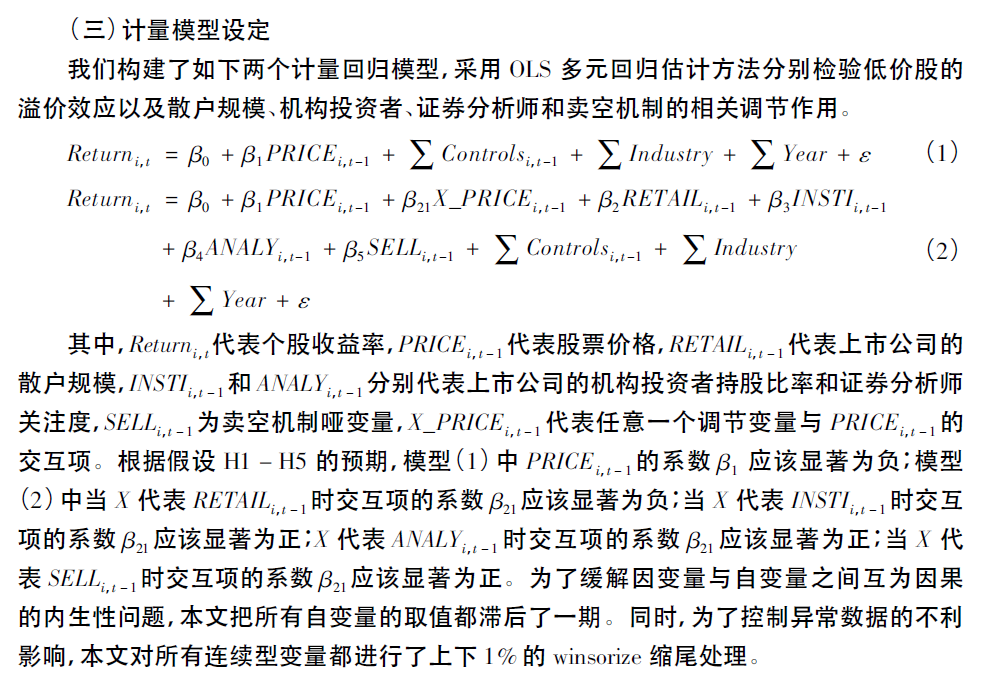

In [5]:
stock = pd.read_csv("all_v.csv",index_col=0)
stock['month'] = stock['month'].apply(lambda x:datetime.strptime(str(x)[:-2],'%Y%m'))

In [6]:
stock[['Return','price','retail','insti','analy','sell']].describe().T

,count,mean,std,min,25%,50%,75%,max
Return,187066.0,1.131885,13.283001,-29.874725,-7.217250,0.214500,8.422225,44.222320
price,187066.0,11.088375,8.272776,2.340000,5.810000,8.710000,13.550000,54.130000
retail,187066.0,1.125327,0.636034,0.152353,0.651324,1.011236,1.477103,3.130320
insti,187066.0,24.609008,23.018257,0.003763,2.866033,18.176457,42.506496,81.052691
analy,187066.0,0.272164,0.563325,0.000000,0.000000,0.000000,0.000000,2.484907
sell,187066.0,0.075155,0.263642,0.000000,0.000000,0.000000,0.000000,1.000000


![img](summary_statistic.PNG)

In [3]:
stock_ahead = stock.copy()
stock_ahead['month'] = stock['month']-MonthBegin(1)
stock_ahead = stock_ahead[['stkcd','month','Return']].rename(columns = {'Return':'return_ahead'})
stock_ahead_1 = stock.copy()
stock_ahead_1['month'] = stock['month']-MonthBegin(2)
stock_ahead_1 = stock_ahead_1[['stkcd','month','Return']].rename(columns = {'Return':'return_ahead_1'})
stock_ahead_2 = stock.copy()
stock_ahead_2['month'] = stock['month']-MonthBegin(3)
stock_ahead_2 = stock_ahead_2[['stkcd','month','Return']].rename(columns = {'Return':'return_ahead_2'})
stock_ahead_3 = stock.copy()
stock_ahead_3['month'] = stock['month']-MonthBegin(4)
stock_ahead_3 = stock_ahead_3[['stkcd','month','Return']].rename(columns = {'Return':'return_ahead_3'})
stock_ahead_4 = stock.copy()
stock_ahead_4['month'] = stock['month']-MonthBegin(5)
stock_ahead_4 = stock_ahead_4[['stkcd','month','Return']].rename(columns = {'Return':'return_ahead_4'})
stock_ahead_5 = stock.copy()
stock_ahead_5['month'] = stock['month']-MonthBegin(6)
stock_ahead_5 = stock_ahead_5[['stkcd','month','Return']].rename(columns = {'Return':'return_ahead_5'})

In [4]:
stock = pd.merge(stock,stock_ahead,on=['stkcd','month'])
stock = pd.merge(stock,stock_ahead_1,on=['stkcd','month'])
stock = pd.merge(stock,stock_ahead_2,on=['stkcd','month'])
stock = pd.merge(stock,stock_ahead_3,on=['stkcd','month'])
stock = pd.merge(stock,stock_ahead_4,on=['stkcd','month'])
stock = pd.merge(stock,stock_ahead_5,on=['stkcd','month'])

In [6]:
stock = stock.drop(stock[stock['mtb']==np.inf].index)

In [7]:
independent_list = stock[['price','Return','tur','beta','mtb','roa','cash','eps','lev','size','age','illiq','retnmax','idvol','skew', 'coskew',
                         '2001', '2002', '2003', '2004','2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013','2014', 
                         'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M']]

In [8]:
est1 = sm.OLS(endog=stock['return_ahead'], exog=sm.add_constant(independent_list)).fit()
est2 = sm.OLS(endog=stock['return_ahead_1'], exog=sm.add_constant(independent_list)).fit()
est3 = sm.OLS(endog=stock['return_ahead_2'], exog=sm.add_constant(independent_list)).fit()
est4 = sm.OLS(endog=stock['return_ahead_3'], exog=sm.add_constant(independent_list)).fit()
est5 = sm.OLS(endog=stock['return_ahead_4'], exog=sm.add_constant(independent_list)).fit()
est6 = sm.OLS(endog=stock['return_ahead_5'], exog=sm.add_constant(independent_list)).fit()

![img](table3.jpg)

In [9]:
model1 = smf.ols("return_ahead ~ price+retail*price+retail+insti+analy+sell+Return+tur+beta+mtb+roa+cash+eps+lev+size+age+illiq+retnmax+idvol+skew+coskew+Q('2001')+Q('2002')+Q('2003')+Q('2004')+Q('2005')+Q('2006')+Q('2007')+Q('2008')+Q('2009')+Q('2010')+Q('2011')+Q('2012')+Q('2013')+Q('2014')+B+C+D+E+F+G+H+J+K+L+M", data = stock).fit()
model2 = smf.ols("return_ahead ~ price+insti*price+retail+insti+analy+sell+Return+tur+beta+mtb+roa+cash+eps+lev+size+age+illiq+retnmax+idvol+skew+coskew+Q('2001')+Q('2002')+Q('2003')+Q('2004')+Q('2005')+Q('2006')+Q('2007')+Q('2008')+Q('2009')+Q('2010')+Q('2011')+Q('2012')+Q('2013')+Q('2014')+B+C+D+E+F+G+H+J+K+L+M", data = stock).fit()
model3 = smf.ols("return_ahead ~ price+analy*price+retail+insti+analy+sell+Return+tur+beta+mtb+roa+cash+eps+lev+size+age+illiq+retnmax+idvol+skew+coskew+Q('2001')+Q('2002')+Q('2003')+Q('2004')+Q('2005')+Q('2006')+Q('2007')+Q('2008')+Q('2009')+Q('2010')+Q('2011')+Q('2012')+Q('2013')+Q('2014')+B+C+D+E+F+G+H+J+K+L+M", data = stock).fit()
model4 = smf.ols("return_ahead ~ price+sell*price+retail+insti+analy+sell+Return+tur+beta+mtb+roa+cash+eps+lev+size+age+illiq+retnmax+idvol+skew+coskew+Q('2001')+Q('2002')+Q('2003')+Q('2004')+Q('2005')+Q('2006')+Q('2007')+Q('2008')+Q('2009')+Q('2010')+Q('2011')+Q('2012')+Q('2013')+Q('2014')+B+C+D+E+F+G+H+J+K+L+M", data = stock).fit()

![img](table4.jpg)

In [10]:
Bull = stock[stock['period']=='Bull']
Bear = stock[stock['period']=='Bear']

model5 = smf.ols("return_ahead ~ price+retail*price+retail+insti+analy+sell+Return+tur+beta+mtb+roa+cash+eps+lev+size+age+illiq+retnmax+idvol+skew+coskew+Q('2001')+Q('2002')+Q('2003')+Q('2004')+Q('2005')+Q('2006')+Q('2007')+Q('2008')+Q('2009')+Q('2010')+Q('2011')+Q('2012')+Q('2013')+Q('2014')+B+C+D+E+F+G+H+J+K+L+M", data = Bull).fit()
model6 = smf.ols("return_ahead ~ price+insti*price+retail+insti+analy+sell+Return+tur+beta+mtb+roa+cash+eps+lev+size+age+illiq+retnmax+idvol+skew+coskew+Q('2001')+Q('2002')+Q('2003')+Q('2004')+Q('2005')+Q('2006')+Q('2007')+Q('2008')+Q('2009')+Q('2010')+Q('2011')+Q('2012')+Q('2013')+Q('2014')+B+C+D+E+F+G+H+J+K+L+M", data = Bull).fit()
model7 = smf.ols("return_ahead ~ price+analy*price+retail+insti+analy+sell+Return+tur+beta+mtb+roa+cash+eps+lev+size+age+illiq+retnmax+idvol+skew+coskew+Q('2001')+Q('2002')+Q('2003')+Q('2004')+Q('2005')+Q('2006')+Q('2007')+Q('2008')+Q('2009')+Q('2010')+Q('2011')+Q('2012')+Q('2013')+Q('2014')+B+C+D+E+F+G+H+J+K+L+M", data = Bull).fit()
model8 = smf.ols("return_ahead ~ price+sell*price+retail+insti+analy+sell+Return+tur+beta+mtb+roa+cash+eps+lev+size+age+illiq+retnmax+idvol+skew+coskew+Q('2001')+Q('2002')+Q('2003')+Q('2004')+Q('2005')+Q('2006')+Q('2007')+Q('2008')+Q('2009')+Q('2010')+Q('2011')+Q('2012')+Q('2013')+Q('2014')+B+C+D+E+F+G+H+J+K+L+M", data = Bull).fit()

model9 = smf.ols("return_ahead ~ price+retail*price+retail+insti+analy+sell+Return+tur+beta+mtb+roa+cash+eps+lev+size+age+illiq+retnmax+idvol+skew+coskew+Q('2001')+Q('2002')+Q('2003')+Q('2004')+Q('2005')+Q('2006')+Q('2007')+Q('2008')+Q('2009')+Q('2010')+Q('2011')+Q('2012')+Q('2013')+Q('2014')+B+C+D+E+F+G+H+J+K+L+M", data = Bear).fit()
model10 = smf.ols("return_ahead ~ price+insti*price+retail+insti+analy+sell+Return+tur+beta+mtb+roa+cash+eps+lev+size+age+illiq+retnmax+idvol+skew+coskew+Q('2001')+Q('2002')+Q('2003')+Q('2004')+Q('2005')+Q('2006')+Q('2007')+Q('2008')+Q('2009')+Q('2010')+Q('2011')+Q('2012')+Q('2013')+Q('2014')+B+C+D+E+F+G+H+J+K+L+M", data = Bear).fit()
model11 = smf.ols("return_ahead ~ price+analy*price+retail+insti+analy+sell+Return+tur+beta+mtb+roa+cash+eps+lev+size+age+illiq+retnmax+idvol+skew+coskew+Q('2001')+Q('2002')+Q('2003')+Q('2004')+Q('2005')+Q('2006')+Q('2007')+Q('2008')+Q('2009')+Q('2010')+Q('2011')+Q('2012')+Q('2013')+Q('2014')+B+C+D+E+F+G+H+J+K+L+M", data = Bear).fit()
model12 = smf.ols("return_ahead ~ price+sell*price+retail+insti+analy+sell+Return+tur+beta+mtb+roa+cash+eps+lev+size+age+illiq+retnmax+idvol+skew+coskew+Q('2001')+Q('2002')+Q('2003')+Q('2004')+Q('2005')+Q('2006')+Q('2007')+Q('2008')+Q('2009')+Q('2010')+Q('2011')+Q('2012')+Q('2013')+Q('2014')+B+C+D+E+F+G+H+J+K+L+M", data = Bear).fit()

![img](table5.jpg)

以上为采用原文章截止2014年底的数据，下为采用截止2020年底的数据回归结果。
![img](table3_2020.jpg)
![img](table4_2020.jpg)
![img](table5_2020.jpg)